## Avocado Harvesters - Predicting Future Sales
 

In [1]:
# pip install seaborn  # not sure why needed to reinstall, but went w/o incident
# !pip uninstall -y prophet
# !pip uninstall -y cmdstanpy
# !pip install prophet

In [2]:
# Import Dependancies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from prophet import Prophet


In [3]:
# Import dataset from kaggle Source location (downloaded from): "https://www.kaggle.com/datasets/neuromusic/avocado-prices/data"
avo_data = pd.read_csv("./Resources/avocado.csv")

# avo_data.tail()


In [4]:
# NOT ACTIVE IN CODE
# ORIGINAL:  Drop 'type' column (as we want to look at all avocados and not differentiate between organic or conventional)
# avo_data_df = avo_data.drop("type", axis=1)

# sorted_df = avo_data_df[(avo_data_df["region"] == 'ALbany') & (avo_data_df["Date"] == "2015-12-27")]
# sorted_df = avo_data_df.sort_values(by=["region", "Date"])
# sorted_df.head()


In [5]:
# Drop 'Unnamed: 0' Index column, Set the Date column as the index 
avo_data_df = avo_data.drop("Unnamed: 0", axis=1)

avo_data_df = avo_data_df.set_index("Date")
# avo_data_df.head()

In [6]:
# Identify unique regions (Total US, vs. Regions, vs. cities)
# print(sorted(avo_data_df['region'].unique()))

### Notes on Data Clean up at this point 
List of Cities in DF:
'Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester', 'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale', 'Nashville', 'NewOrleansMobile', 'NewYork', 'Orlando', 'Philadelphia', 'PhoenixTucson', 'Pittsburgh', 'Portland', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',  'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'WestTexNewMexico', 'NorthernNewEngland'

### and create a "Total US" dataframe if needed for future use
'TotalUS',
 
### and create a Regions dataframe if needed for future use:
'California', 'GreatLakes', 'West', 'Midsouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast'

In [7]:
# MISC NOTES NOT ACTIVE IN CODE
# # Marketing Data from DMA (DEsignated Marketing Areas)
# Maybe Missing Data - Create Counts (Are we safe to assume Regions = Cumulative City counts)
# Calc the math


In [8]:

# Seperate the data (remove rows with regions and 'Total US') in Region column (only keep cities)
# Create a Regions DF, and a TotalUS dataframe:
regions = ['California', 'GreatLakes', 'Midsouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast', 'West']

# Create a DF for TotalUS:
totalus_df =  avo_data_df[avo_data_df['region'] == 'TotalUS'].copy()

# Create a DF for Regions:
regions_df = avo_data_df[avo_data_df['region'].isin(regions)].copy()
avo_cities_df = avo_data_df[~avo_data_df['region'].isin(['TotalUS'] + regions)].copy()

# Verify
# totalus_df.head()
# avo_cities_df.tail(20)
# regions_dfhead(5)

# Create path to Resources Directory and Save df files
resources_path = "Resources/"
totalus_df.to_csv(resources_path + "Total_US.csv", index=False)
regions_df.to_csv(resources_path + "Total_avo_Regions.csv", index=False)
avo_cities_df.to_csv(resources_path + "Total_avo_Cities.csv", index=False)

avo_cities_df.tail(2)



,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [9]:
# Combine PLU codes to Bag sizes to get Total Avocados for Small, Large & XLarge Avocados
# Start with a copy of the Avocado Cities DF 
df = avo_cities_df.copy()
df["Ttl_Small"] = df["4046"] + df["Small Bags"]
df["Ttl_Large"] = df["4225"] + df["Large Bags"]

# Drop the original columns and the Total Bags column
df = df.drop(columns=["Total Volume", "4046", "4225", "4770", "Total Bags", "Small Bags", "Large Bags", "XLarge Bags"])

# Rename Lower-case Column titles to Upper-case
df = df.rename(columns={"year": "Year", "region": "City", "type": "Type"})

# display head of DataFrame
df.head()



,AveragePrice,Type,Year,City,Ttl_Small,Ttl_Large
Date,,,,,,
2015-12-27,1.33,conventional,2015,Albany,9640.36,54548.10
2015-12-20,1.35,conventional,2015,Albany,10082.35,44736.30
2015-12-13,0.93,conventional,2015,Albany,8836.91,109252.81
2015-12-06,1.08,conventional,2015,Albany,6809.40,72110.17
2015-11-29,1.28,conventional,2015,Albany,6927.74,44036.08


In [10]:
# Convert Float columns to Integers 
columns_to_convert = ["Ttl_Small", "Ttl_Large"]	
df[columns_to_convert] = df[columns_to_convert].astype(int)
# df.info()

# Check Counts of Zeros / Nulls  possibly use Imputation & Zero values in dataset (likely valuable data and we do NOT want to drop.na's)
# for Colums and get a % of total 
# df.head() 
# df.count()
# df.describe
# df.info()
# df.isnull().sum()

print(f"Number of Zeros in the Data:", (df['Ttl_Small'] == 0).sum())
# df.count.isnull.sum()
df.head()

Number of Zeros in the Data: 1


,AveragePrice,Type,Year,City,Ttl_Small,Ttl_Large
Date,,,,,,
2015-12-27,1.33,conventional,2015,Albany,9640,54548
2015-12-20,1.35,conventional,2015,Albany,10082,44736
2015-12-13,0.93,conventional,2015,Albany,8836,109252
2015-12-06,1.08,conventional,2015,Albany,6809,72110
2015-11-29,1.28,conventional,2015,Albany,6927,44036


In [11]:
# Drop the 22 rows with Null values (out of 15207 rows)
df.drop(df[df["Ttl_Small"] == 0].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15117 entries, 2015-12-27 to 2018-01-07
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AveragePrice  15117 non-null  float64
 1   Type          15117 non-null  object 
 2   Year          15117 non-null  int64  
 3   City          15117 non-null  object 
 4   Ttl_Small     15117 non-null  int64  
 5   Ttl_Large     15117 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 826.7+ KB


In [12]:
# Need to be able to see months and seasonality
# First, set the Index to DateTime for future calculations / operations
df.index = pd.to_datetime(df.index)

# Create columns for Months, Year & Seasons
df['Month'] = df.index.strftime('%B')
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
           5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
           9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
df['Season'] = df.index.month.map(seasons)
# df.tail(5)


In [14]:
# Encode Names / Strings to Integers using OneHotEncoder
categorical_cols = ['City', 'Month', 'Season', 'Type']
one_hot_encoder = pd.get_dummies(df[categorical_cols])
df_encoded = df.drop(categorical_cols, axis=1).join(one_hot_encoder)
# df_encoded.info
# df_encoded.to_csv(resources_path + "df_encoded 3-15-2025.csv", index=False)
print(df_encoded.columns)

Index(['AveragePrice', 'Year', 'Ttl_Small', 'Ttl_Large', 'City_Albany',
       'City_Atlanta', 'City_BaltimoreWashington', 'City_Boise', 'City_Boston',
       'City_BuffaloRochester', 'City_Charlotte', 'City_Chicago',
       'City_CincinnatiDayton', 'City_Columbus', 'City_DallasFtWorth',
       'City_Denver', 'City_Detroit', 'City_GrandRapids',
       'City_HarrisburgScranton', 'City_HartfordSpringfield', 'City_Houston',
       'City_Indianapolis', 'City_Jacksonville', 'City_LasVegas',
       'City_LosAngeles', 'City_Louisville', 'City_MiamiFtLauderdale',
       'City_Nashville', 'City_NewOrleansMobile', 'City_NewYork',
       'City_NorthernNewEngland', 'City_Orlando', 'City_Philadelphia',
       'City_PhoenixTucson', 'City_Pittsburgh', 'City_Portland',
       'City_RaleighGreensboro', 'City_RichmondNorfolk', 'City_Roanoke',
       'City_Sacramento', 'City_SanDiego', 'City_SanFrancisco', 'City_Seattle',
       'City_SouthCarolina', 'City_Spokane', 'City_StLouis', 'City_Syracuse',
     

## Visualize the Avocado Harvester Data Frame:

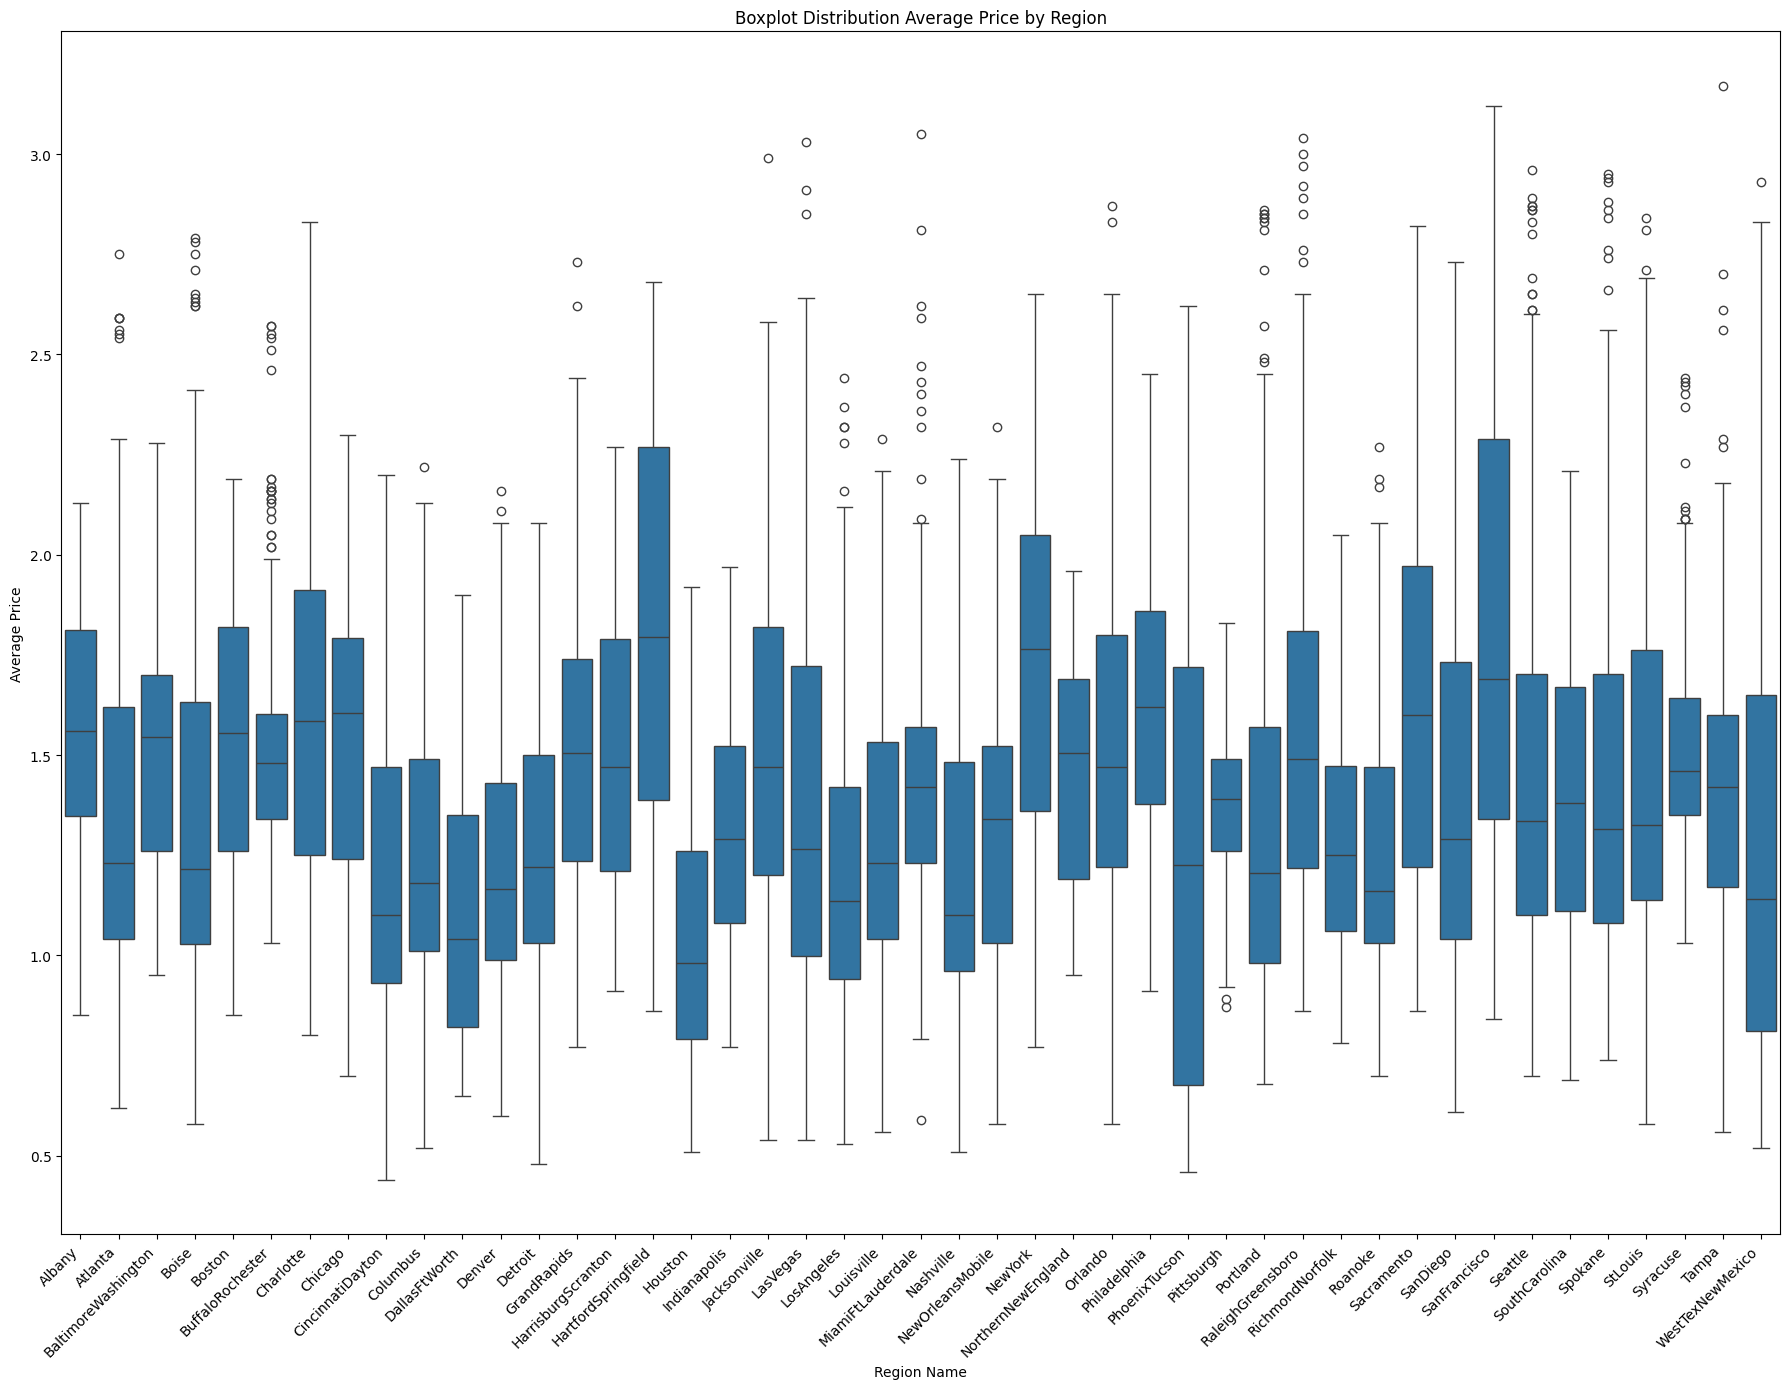

In [ ]:
# Visulize with a BOX Plot of Average Price by city (for all months & years in the dataset)
plt.figure(figsize=(18, 14))
ax = sns.boxplot(x='City', y='AveragePrice', data=df)
ax.set_xlabel("Region Name")
ax.set_ylabel("Average Price")
plt.title('Boxplot Distribution Average Price by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


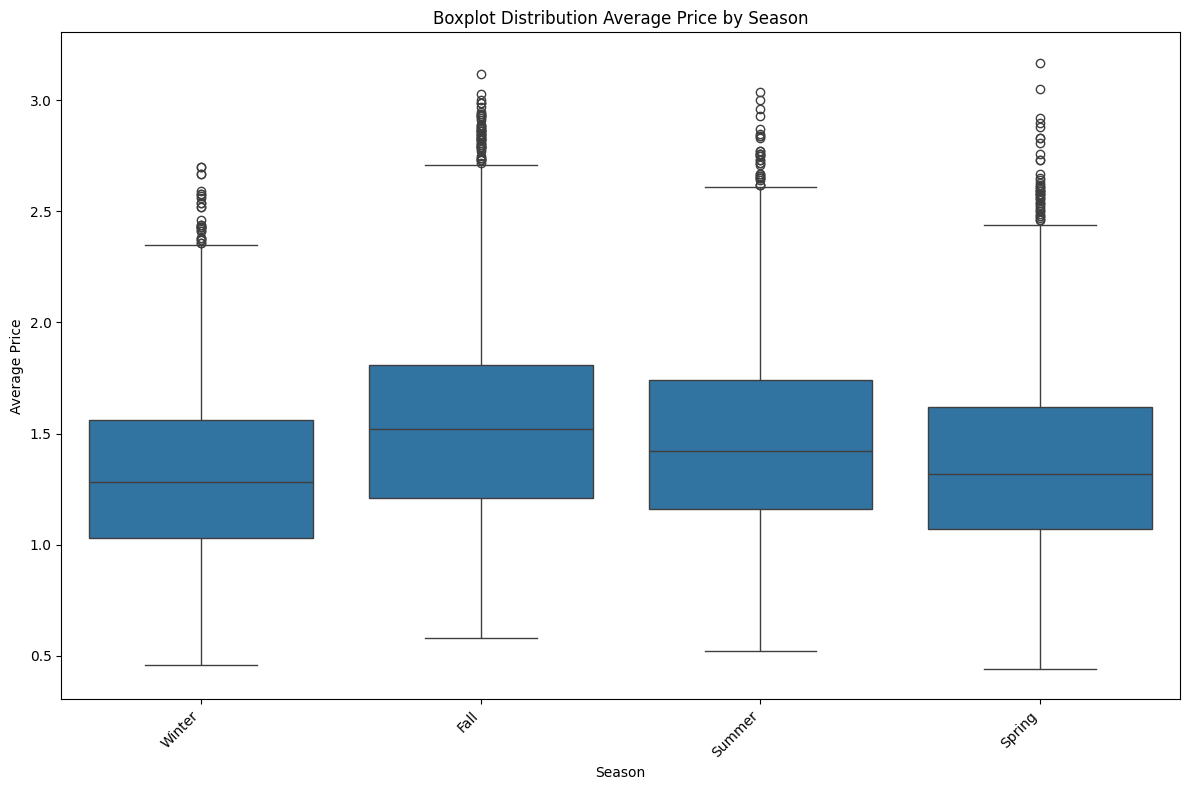

In [ ]:
# Visulize with a BOX Plot of Average Price by Season (for all months & years in the dataset)
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Season', y='AveragePrice', data=df)
ax.set_xlabel("Season")
ax.set_ylabel("Average Price")
plt.title('Boxplot Distribution Average Price by Season')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# WHY are there so many Outliers with higher prices ?

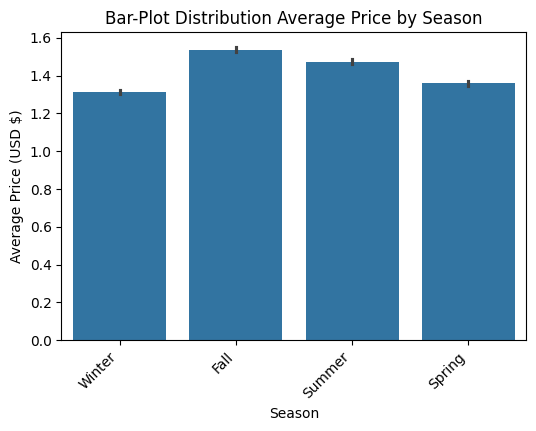

In [ ]:
# Look at Price by Season w/ a Bar-Plot across all cities

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Season', y='AveragePrice', data=df)
ax.set_xlabel("Season")
ax.set_ylabel("Average Price (USD $)")
plt.title('Bar-Plot Distribution Average Price by Season')
plt.xticks(rotation=45, ha='right')
plt.constrained_layout=True

plt.show()

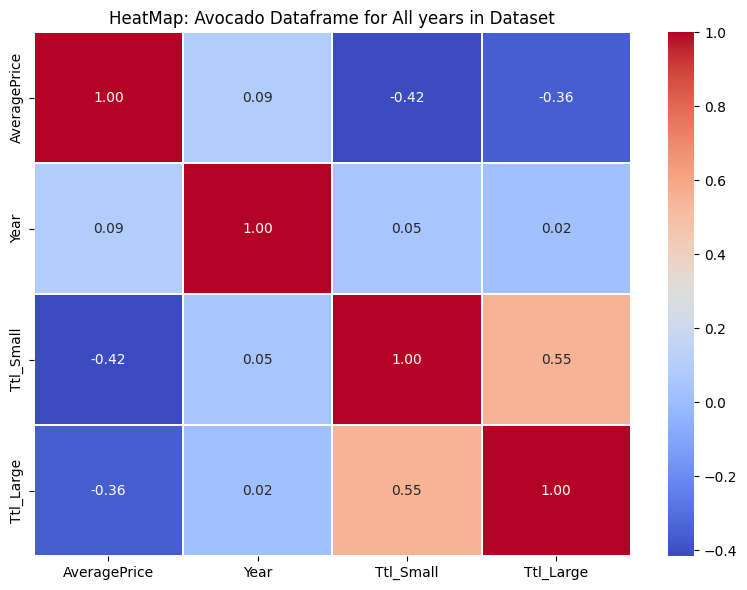

In [ ]:
# HeatMap on Numeric columns  

numeric_columns = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(8, 6))
correlation = df[numeric_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.25)
plt.title('HeatMap: Avocado Dataframe for All years in Dataset')
plt.tight_layout()
plt.show()


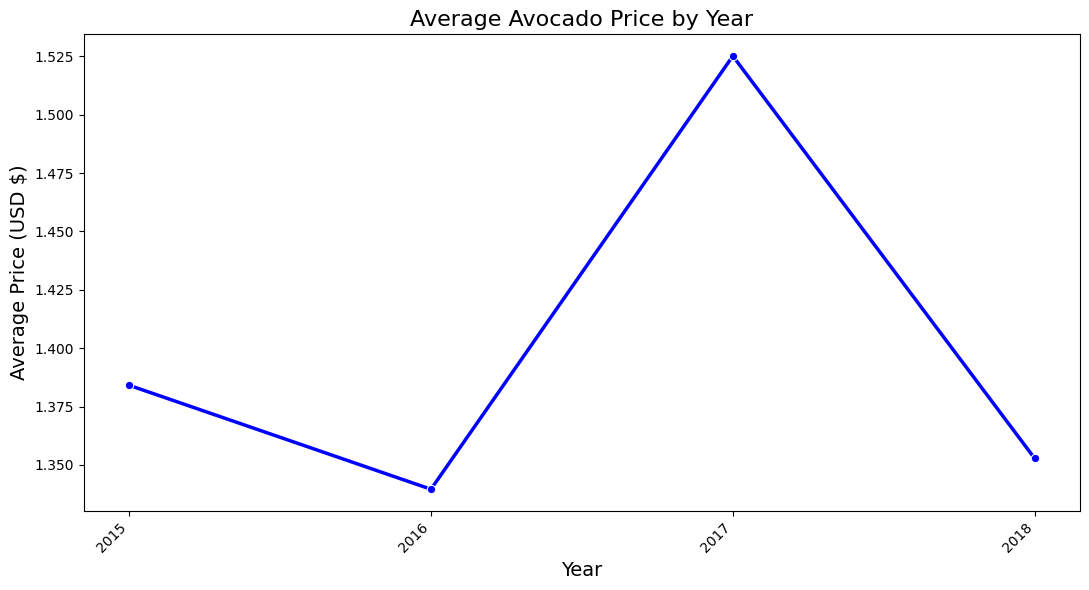

In [ ]:
# Quick Line Plot of Total Small & Large Avocados by Year
yearly_average = df.groupby('Year')["AveragePrice"].mean().reset_index()

plt.figure(figsize=(11, 6))
sns.lineplot(x="Year", y="AveragePrice", data=yearly_average, marker="o", color="blue", linewidth=2.5)
plt.title('Average Avocado Price by Year', fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Price (USD $)", fontsize=14)
years = sorted(df["Year"].unique())
plt.xticks(years, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
# Estimate how Small Avocado prices will fluctuate throughout 2018 Using a Random Forest Regression Model 
features = df_encoded.drop(columns=["AveragePrice", "Ttl_Large", 'City_Albany',
       'City_Atlanta', 'City_BaltimoreWashington', 'City_Boise', 'City_Boston',
       'City_BuffaloRochester', 'City_Charlotte', 'City_Chicago',
       'City_CincinnatiDayton', 'City_Columbus', 'City_DallasFtWorth',
       'City_Denver', 'City_Detroit', 'City_GrandRapids',
       'City_HarrisburgScranton', 'City_HartfordSpringfield', 'City_Houston',
       'City_Indianapolis', 'City_Jacksonville', 'City_LasVegas',
       'City_LosAngeles', 'City_Louisville', 'City_MiamiFtLauderdale',
       'City_Nashville', 'City_NewOrleansMobile', 'City_NewYork',
       'City_NorthernNewEngland', 'City_Orlando', 'City_Philadelphia',
       'City_PhoenixTucson', 'City_Pittsburgh', 'City_Portland',
       'City_RaleighGreensboro', 'City_RichmondNorfolk', 'City_Roanoke',
       'City_Sacramento', 'City_SanDiego', 'City_SanFrancisco', 'City_Seattle',
       'City_SouthCarolina', 'City_Spokane', 'City_StLouis', 'City_Syracuse',
       'City_Tampa', 'City_WestTexNewMexico'], axis=1)
target = df_encoded["AveragePrice"] 

# Convert & Sort the Date index to a column for the Random Forest Regression Model
df_encoded.index = pd.to_datetime(df_encoded.index)
df_encoded = df_encoded.sort_index()

# Train the Small Avocado RF Model on 2015-2017 data using the index to filter the data
train_mask = df_encoded.index < pd.to_datetime("2018-01-01")
train_data = df_encoded[train_mask]

# Extraaxt X & Y values for the Train set
X_train = train_data.drop(columns=["AveragePrice", "Ttl_Large"], axis=1)
y_train = train_data["AveragePrice"]

# Train the Random Forest Regressor Model on the Train set and predict
rf_model = RandomForestRegressor(
    n_estimators=40, 
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    random_state=42,
    n_jobs=1)  
# Fit the RF Model to the training data
rf_model.fit(X_train, y_train)

# To predit on the 2018 Data: Create a mask for the 2018 data and extract the X & Y values
test_mask = df_encoded.index >= pd.to_datetime("2018-01-01")
if sum(test_mask) > 0:
    test_data = df_encoded[test_mask]
    X_test = test_data.drop(columns=["AveragePrice", "Ttl_Large"], axis=1)
    y_test = test_data["AveragePrice"]

    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f})")



MSE: 0.067585, RMSE: 0.2600, R^2: 0.2994)


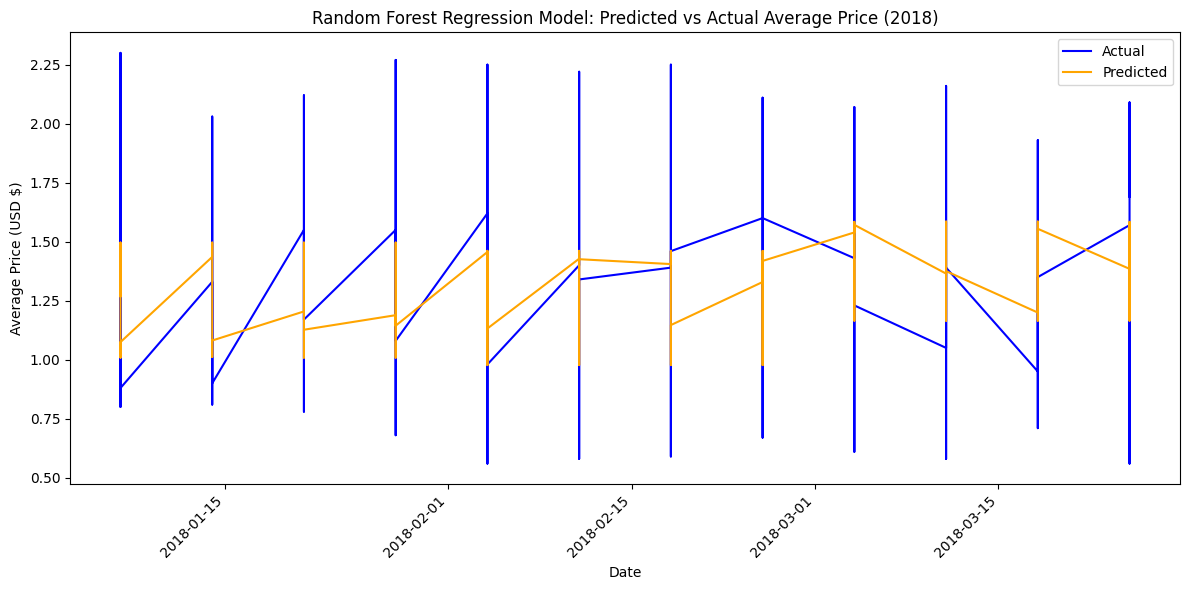

In [17]:
# Visualize the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label="Actual", color="blue")
plt.plot(test_data.index, y_pred, label="Predicted", color="orange")
plt.xlabel("Date")
plt.ylabel("Average Price (USD $)")

plt.title("Random Forest Regression Model: Predicted vs Actual Average Price (2018)")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Build a Linear Regression Model to predict the Average Price of Avocados 
# Split the data into Training and Testing datasets
# Check Actual Data Prices - Help Understand the "Artificial Price of the LR Model" (and how it compares to the actual data)
# ALSO DOUBLE CHECK the Underlying Model Data - Train & Test 
# Yalue Predicted -- > Then Make the PREDICTION

features = ["Year", "Ttl_Small", "Ttl_Large"]

# Adding in the OneHotEncoded columns for City, Month and Season
month_columns = [col for col in df_encoded.columns if col.startswith('Month_')]
season_columns = [col for col in df_encoded.columns if col.startswith('Season_')]
type_columns = [col for col in df_encoded.columns if col.startswith('Type_')]

# Features now also include encoded: City, Ttl_Large, Month, Season data
features = features + month_columns + season_columns + type_columns

X = df_encoded[features]
# X.head()

In [ ]:
# Set the target variable y to the Average Price
y = df_encoded["AveragePrice"]
# y.head()

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
model = LinearRegression()

# Fit the model to the training data. 
model.fit(X_train, y_train)

LinearRegression()

# With Organic and Conventional avocados included in the dataset, the Modle does not perform very well - only predicting ~ 1/4 of Variance 
# Mean Squared Error: 0.1251
# Root of the Mean Squared Error: 0.3537
# Mean Absolute Error: 0.2814
# R^ Squared: 0.2644

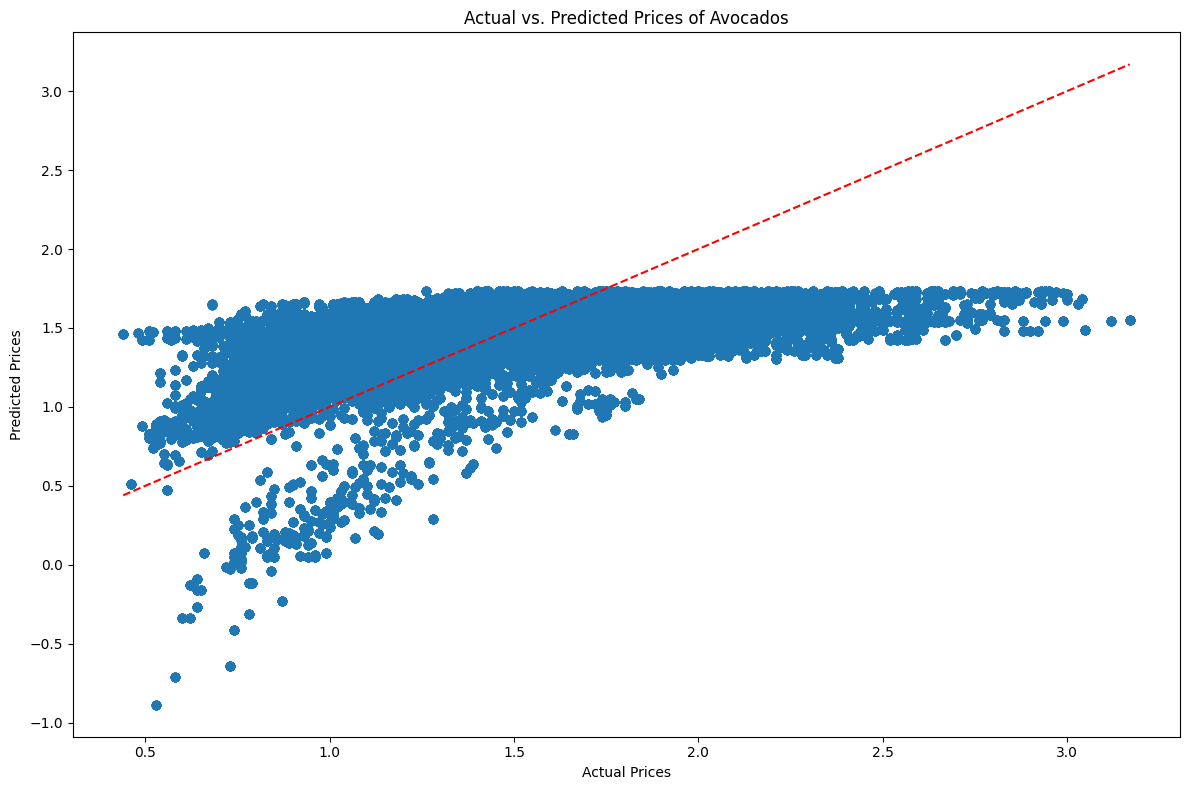

In [ ]:
# Visualize the Linear Regression Model:
# Actual Vs. Predicted Values
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # lw=2, color='red'
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices of Avocados')
plt.grid=True
plt.tight_layout()
# plt.show()


In [ ]:
# Review Performance Metrics

# 1st: Calculate Predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)   

# Print & Review Predictions
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root of the Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R^ Squared: {r2:.4f}")

Mean Squared Error: 0.1251
Root of the Mean Squared Error: 0.3537
Mean Absolute Error: 0.2814
R^ Squared: 0.2644


In [ ]:
# Build a Logistic Regression Model to predict the Average Price of Avocados

In [ ]:
df_encoded.head(1)

,AveragePrice,Year,Ttl_Small,Ttl_Large,City_Albany,City_Atlanta,City_BaltimoreWashington,City_Boise,City_Boston,City_BuffaloRochester,...,Month_May,Month_November,Month_October,Month_September,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Type_conventional,Type_organic
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-27,1.33,2015,9640,54548,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [ ]:
# Prepare Prophet Model to predict the Average Price of Avocados
prophet_df = df_encoded.copy()
prophet_df.reset_index(inplace=True)
prophet_df.rename(columns={"Date": "ds", "AveragePrice": "y"}, inplace=True)
city_columns = [col for col in prophet_df.columns if col.startswith('City_')]
month_columns = [col for col in prophet_df.columns if col.startswith('Month_')]
season_columns = [col for col in prophet_df.columns if col.startswith('Season_')]
type_columns = [col for col in prophet_df.columns if col.startswith('Type_')]
prophet_data = pd.DataFrame({
    'ds': prophet_df['ds'],
    'y': prophet_df['y'],
    'Ttl_Small': prophet_df['Ttl_Small'],
    'Ttl_Large': prophet_df['Ttl_Large'],
    'City': prophet_df[city_columns].idxmax(axis=1),
    'Month': prophet_df[month_columns].idxmax(axis=1),
    'Season': prophet_df[season_columns].idxmax(axis=1),
    'Type': prophet_df[type_columns].idxmax(axis=1)
})
prophet_df.head()

,ds,y,Year,Ttl_Small,Ttl_Large,City_Albany,City_Atlanta,City_BaltimoreWashington,City_Boise,City_Boston,...,Month_May,Month_November,Month_October,Month_September,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Type_conventional,Type_organic
0,2015-12-27,1.33,2015,9640,54548,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,2015-12-27,1.33,2015,9640,54548,False,True,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,2015-12-27,1.33,2015,9640,54548,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False
3,2015-12-27,1.33,2015,9640,54548,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False
4,2015-12-27,1.33,2015,9640,54548,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,False


In [ ]:
# Split the data into training and testing sets for Prophet
prophet_train = prophet_df[prophet_df['ds'] < '2018-01-01']
prophet_test = prophet_df[prophet_df['ds'] >= '2018-01-01']
prophet_train.head()

,ds,y,Year,Ttl_Small,Ttl_Large,City_Albany,City_Atlanta,City_BaltimoreWashington,City_Boise,City_Boston,...,Month_May,Month_November,Month_October,Month_September,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Type_conventional,Type_organic
0,2015-12-27,1.33,2015,9640,54548,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,2015-12-27,1.33,2015,9640,54548,False,True,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,2015-12-27,1.33,2015,9640,54548,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False
3,2015-12-27,1.33,2015,9640,54548,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False
4,2015-12-27,1.33,2015,9640,54548,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,False


In [ ]:
# Buildout & Train the Prophet model 
def train_prophet_model(df):
    model = Prophet()
    model.fit(df)
    return model

20:18:44 - cmdstanpy - INFO - Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'FB Prophet Model Forecasting Organic Avocado Prices with Seasonal Components')

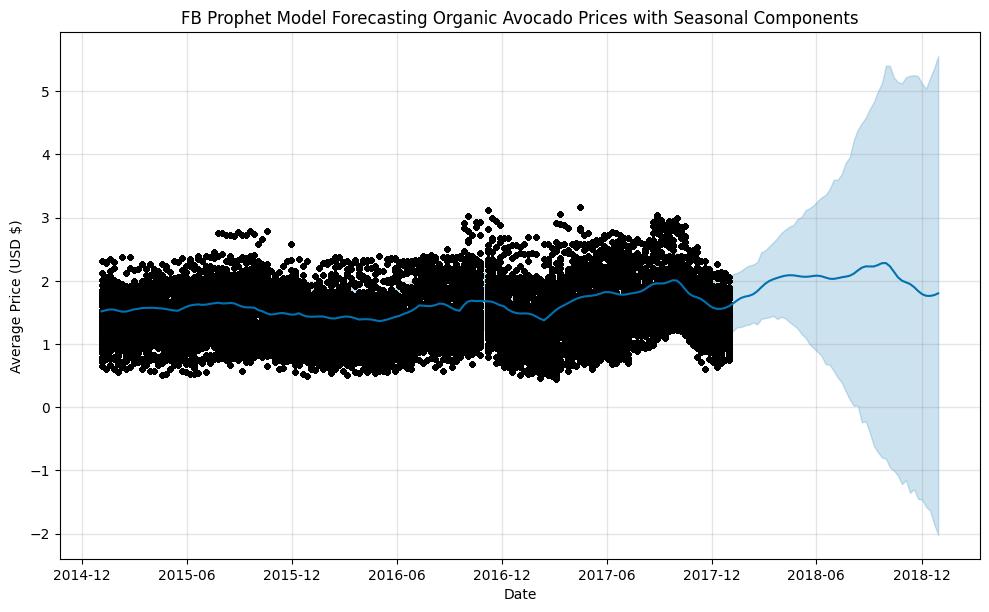

In [ ]:
# FB Prophet Model with Regressors
m = Prophet(
    yearly_seasonality=True, 
    daily_seasonality=False, 
    weekly_seasonality=True,
    seasonality_mode='multiplicative') 

for season in season_columns:
    m.add_regressor(season)

m.add_regressor('Ttl_Small')
m.add_regressor('Ttl_Large')
# m.add_regressor('Type_organic')

m.fit(prophet_train)

# Create future dates for prediction
future = m.make_future_dataframe(periods=52, freq='W')

# add back in the regressor columns to the FB DF
# future['Ttl_Small'] = prophet_train['Ttl_Small'].mean()
# future['Ttl_Large'] = prophet_train['Ttl_Large'].mean()
# future['Type_organic'] = prophet_train['Type_organic'].mean()
for col in season_columns + month_columns + ['Ttl_Small', 'Ttl_Large']:
    future[col] = prophet_train['Type_organic'].mean()

# Make predictions using m.predict 
forecast = m.predict(future)

fig = m.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Average Price (USD $)')
plt.title('FB Prophet Model Forecasting Organic Avocado Prices with Seasonal Components')

In [ ]:
# Calculating the Performance MEtrics of the FB Prophet Model
actuals = prophet_train.copy()
predictions = forecast[forecast['ds'].isin(actuals['ds'])]

# Merge the Data:
evaluation = pd.merge(
    actuals[['ds', 'y']],
    predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    on='ds', 
    how='inner')

# Calc:
mse = mean_squared_error(evaluation['y'], evaluation['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(evaluation['y'], evaluation['yhat'])
r2 = r2_score(evaluation['y'], evaluation['yhat'])
mape = np.mean(np.abs((evaluation['y'] - evaluation['yhat']) / evaluation['y'])) * 100

# Calculate coverage of the prediction intervals
coverage = np.mean((evaluation['y'] >= evaluation['yhat_lower']) 
                   & (evaluation['y'] <= evaluation['yhat_upper'])) * 100

# Display 
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root of the Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R^ Squared: {r2:.4f}")
plt.show()

Mean Squared Error: 0.1854
Root of the Mean Squared Error: 0.4306
Mean Absolute Error: 0.3623
R^ Squared: -0.0601
